# Decompose HSC observed QSO image

This notebook requires standard python libraries and the publicly available packages on github:

- lenstronomy (https://github.com/sibirrer/lenstronomy) (pip install lenstronomy)
    - note: if python2 used, lenstronomy version 1.3.0 version is recommended (pip install lenstronomy==1.3.0 --user)
- regions (pip install regions)
- photutils (pip install photutils)

This notebook has been tested with decompsofile ==  0.1.0

For more information, please contact me: dingxuheng@126.com

This notebook is very similar to the 'decomprofile_HST_QSO.ipynb', only that the noise_map, PSF are input to the fittings. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

#Data is available at: https://drive.google.com/file/d/1ZO9-HzV8K60ijYWK98jGoSoZHjIGW5Lc/view?usp=sharing
fitsFile = pyfits.open('../example_files/HSC/QSO/000017.88+002612.6_HSC-I.fits')

#Load the fov image data:
fov_image = fitsFile[1].data # check the back grounp

#Derive the header informaion, might be used to obtain the pixel scale and the exposure time.
header = fitsFile[1].header # if target position is add in WCS, the header should have the wcs information, i.e. header['EXPTIME']

#Derive the fov noise level map:
err_data= fitsFile[3].data ** 0.5

#Calculate the zeropoint for HSC filters:
file_header0 = fitsFile[0].header
FLUXMAG0 = file_header0['FLUXMAG0']
zp =  2.5 * np.log10(FLUXMAG0)   # This is something Xuheng can't make sure.

#Load the PSF data:
PSF = pyfits.getdata('../example_files/HSC/QSO/000017.88+002612.6_HSC-I_psf.fits')

Estimating the background light ... ... ...
Plot target cut out zoom in:


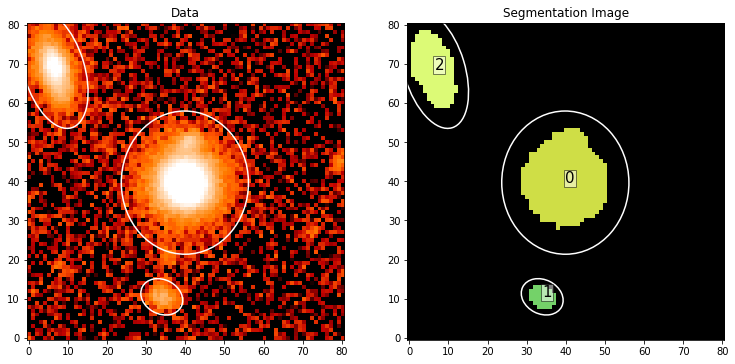

 id xcentroid ycentroid     source_sum         orientation      area
       pix       pix                               deg          pix2
--- --------- --------- ------------------ ------------------- -----
  1     33.97     10.48 14.853843826856933 -26.914715909041405  34.0
  0     39.88     39.65  946.9490094194391   -89.3738147166694 415.0
  2      6.44     68.57  135.4472155124979  -73.06430377562567 169.0
Input directly the a obj idx to mask, use space between each id:



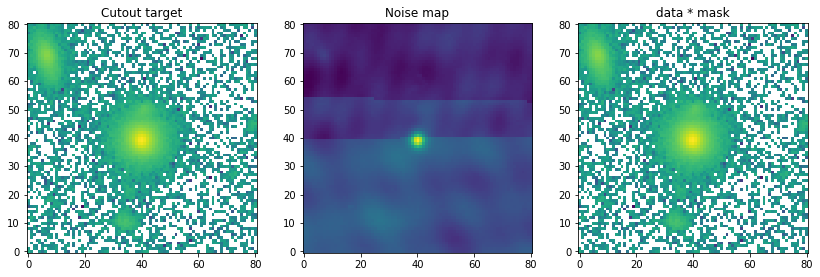

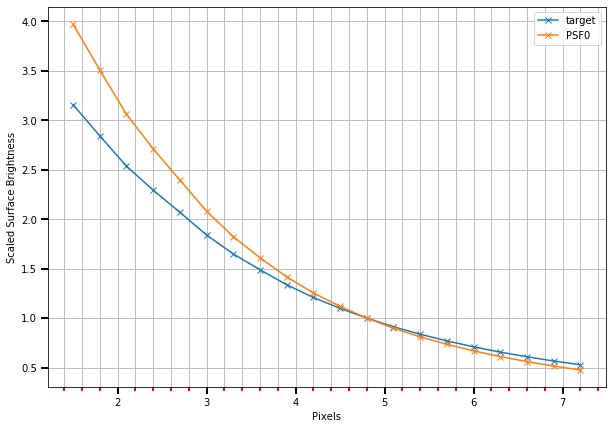

The data_process is ready to go to pass to FittingSpecify!


In [2]:
from decomprofile.data_process import DataProcess

#RA, DEC information of the QSO:
QSO_RA, QSO_DEC = 0.07452999800443649, 0.4368380010128021
data_process = DataProcess(fov_image = fov_image, fov_noise_map = err_data, target_pos = [QSO_RA, QSO_DEC],
                           pos_type = 'wcs', header = header,
                          rm_bkglight = True, if_plot=False, zp = zp)

#Manually input the fov noise map:
data_process.fov_noise_map = err_data

#Generate the fitting materials
data_process.generate_target_materials(radius=None, create_mask = True, nsigma=2.8,
                                      exp_sz= 1.5, npixels = 15, if_plot=True)

#Manually input the PSF:
data_process.PSF_list = [PSF]

# Compare the 1D profile of all the components.
data_process.profiles_compare(norm_pix = 5, if_annuli=False, y_log = False,
                  prf_name_list = (['target'] + ['PSF{0}'.format(i) for i in range(len(data_process.PSF_list))]) )


#Check if all the materials is given, if so to pass to the next step.
data_process.checkout() #Check if all the materials is known.

The settings for the fitting is done. Ready to pass to FittingProcess. 
  However, please make updates manullay if needed.


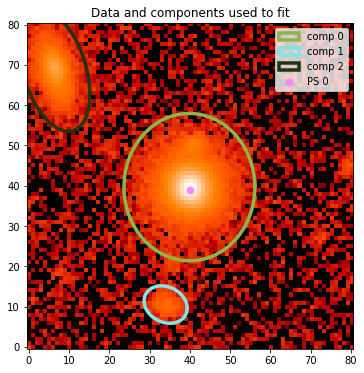

In [3]:
#Start to produce the class and params for lens fitting.
#For more details, see notebook decomprofile_HST_QSO.ipynb
from decomprofile.fitting_specify import FittingSpeficy
fit_sepc = FittingSpeficy(data_process)
fit_sepc.prepare_fitting_seq(point_source_num = 1)
#Using following line: want to fix Sersic_n as 4 for the source_id = 0, and if want to fix the QSO and host center:
# fit_sepc.prepare_fitting_seq(point_source_num = 1, fix_n_list= [[0,4]], fix_center_list = [[0,0]])

#Plot the initial settings for fittings. 
fit_sepc.plot_fitting_sets()

fit_sepc.build_fitting_seq()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Max iteration reached! Stopping.
-1.4188225107186223 reduced X^2 of best position
-4637.421376283817 logL
6537.0 effective number of data points
[] lens result
[{'amp': 1, 'R_sersic': 0.9099735016719593, 'n_sersic': 1.5665666445378341, 'e1': -0.06653421279819964, 'e2': 0.07569191579696247, 'center_x': 0.048262377300754354, 'center_y': -0.057353895482528734}, {'amp': 1, 'R_sersic': 0.4112075606641447, 'n_sersic': 1.9968596413590793, 'e1': 0.4168843120631855, 'e2': -0.1883387952167649, 'center_x': 1.0139176969533001, 'center_y': -4.988345993172458}, {'amp': 1, 'R_sersic': 1.0411396529366312, 'n_sersic': 2.2994427487885196, 'e1': -0.4314220592455494, 'e2': 0.2784848029730032, 'center_x': 5.635098360839926, 'center_y': 4.858686724811777}] source result
[] lens light result
[{'ra_image': array([0.02268641]), 'dec_image': array([-0.11849339]), 'point_amp': [1]}] point source result
{} special param result
96.18040394783

100%|██████████| 130/130 [03:36<00:00,  1.67s/it]


Computing the MCMC...
Number of walkers =  200
Burn-in iterations:  100
Sampling iterations (in current run): 130
218.74830389022827 time taken for MCMC sampling
314.957 total time taken for the overall fitting (s)
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 
Start transfering the Params to fluxs...
6000 MCMC samplers in total, finished translate: 1000
6000 MCMC samplers in total, finished translate: 2000
6000 MCMC samplers in total, finished translate: 3000
6000 MCMC samplers in total, finished translate: 4000
6000 MCMC samplers in total, finished translate: 5000


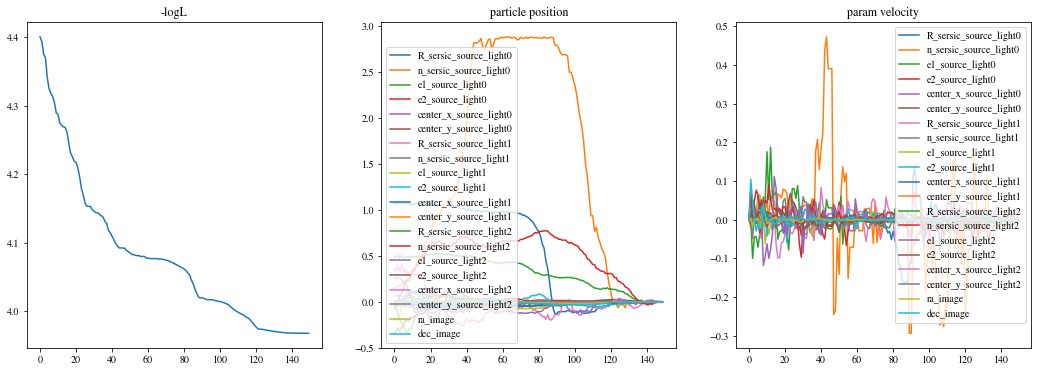

<Figure size 432x288 with 0 Axes>

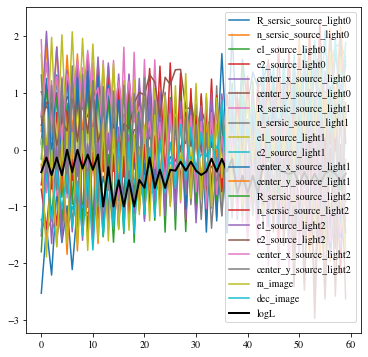

-1.4121282671364233 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.4121282671364233


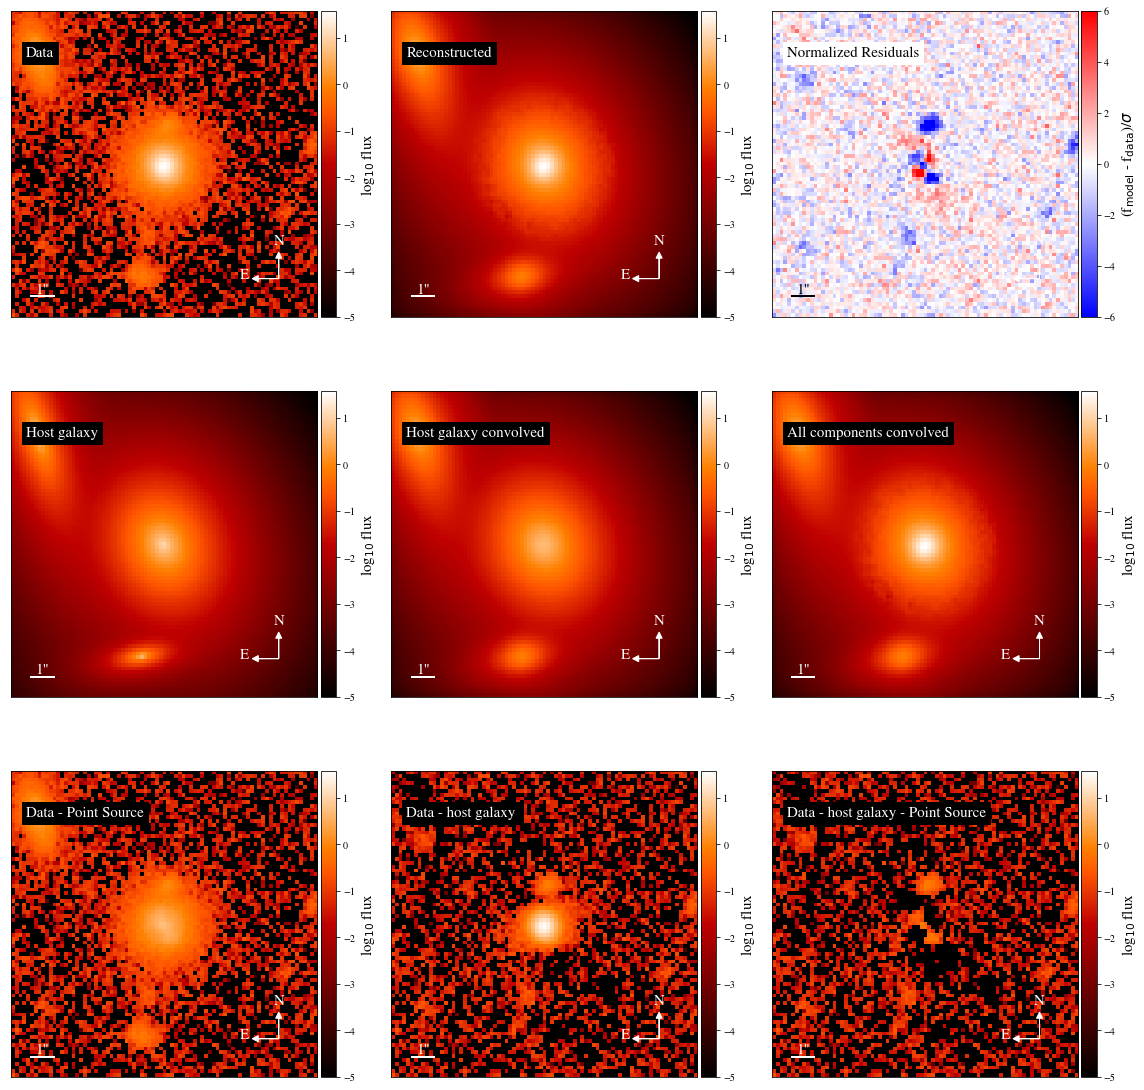

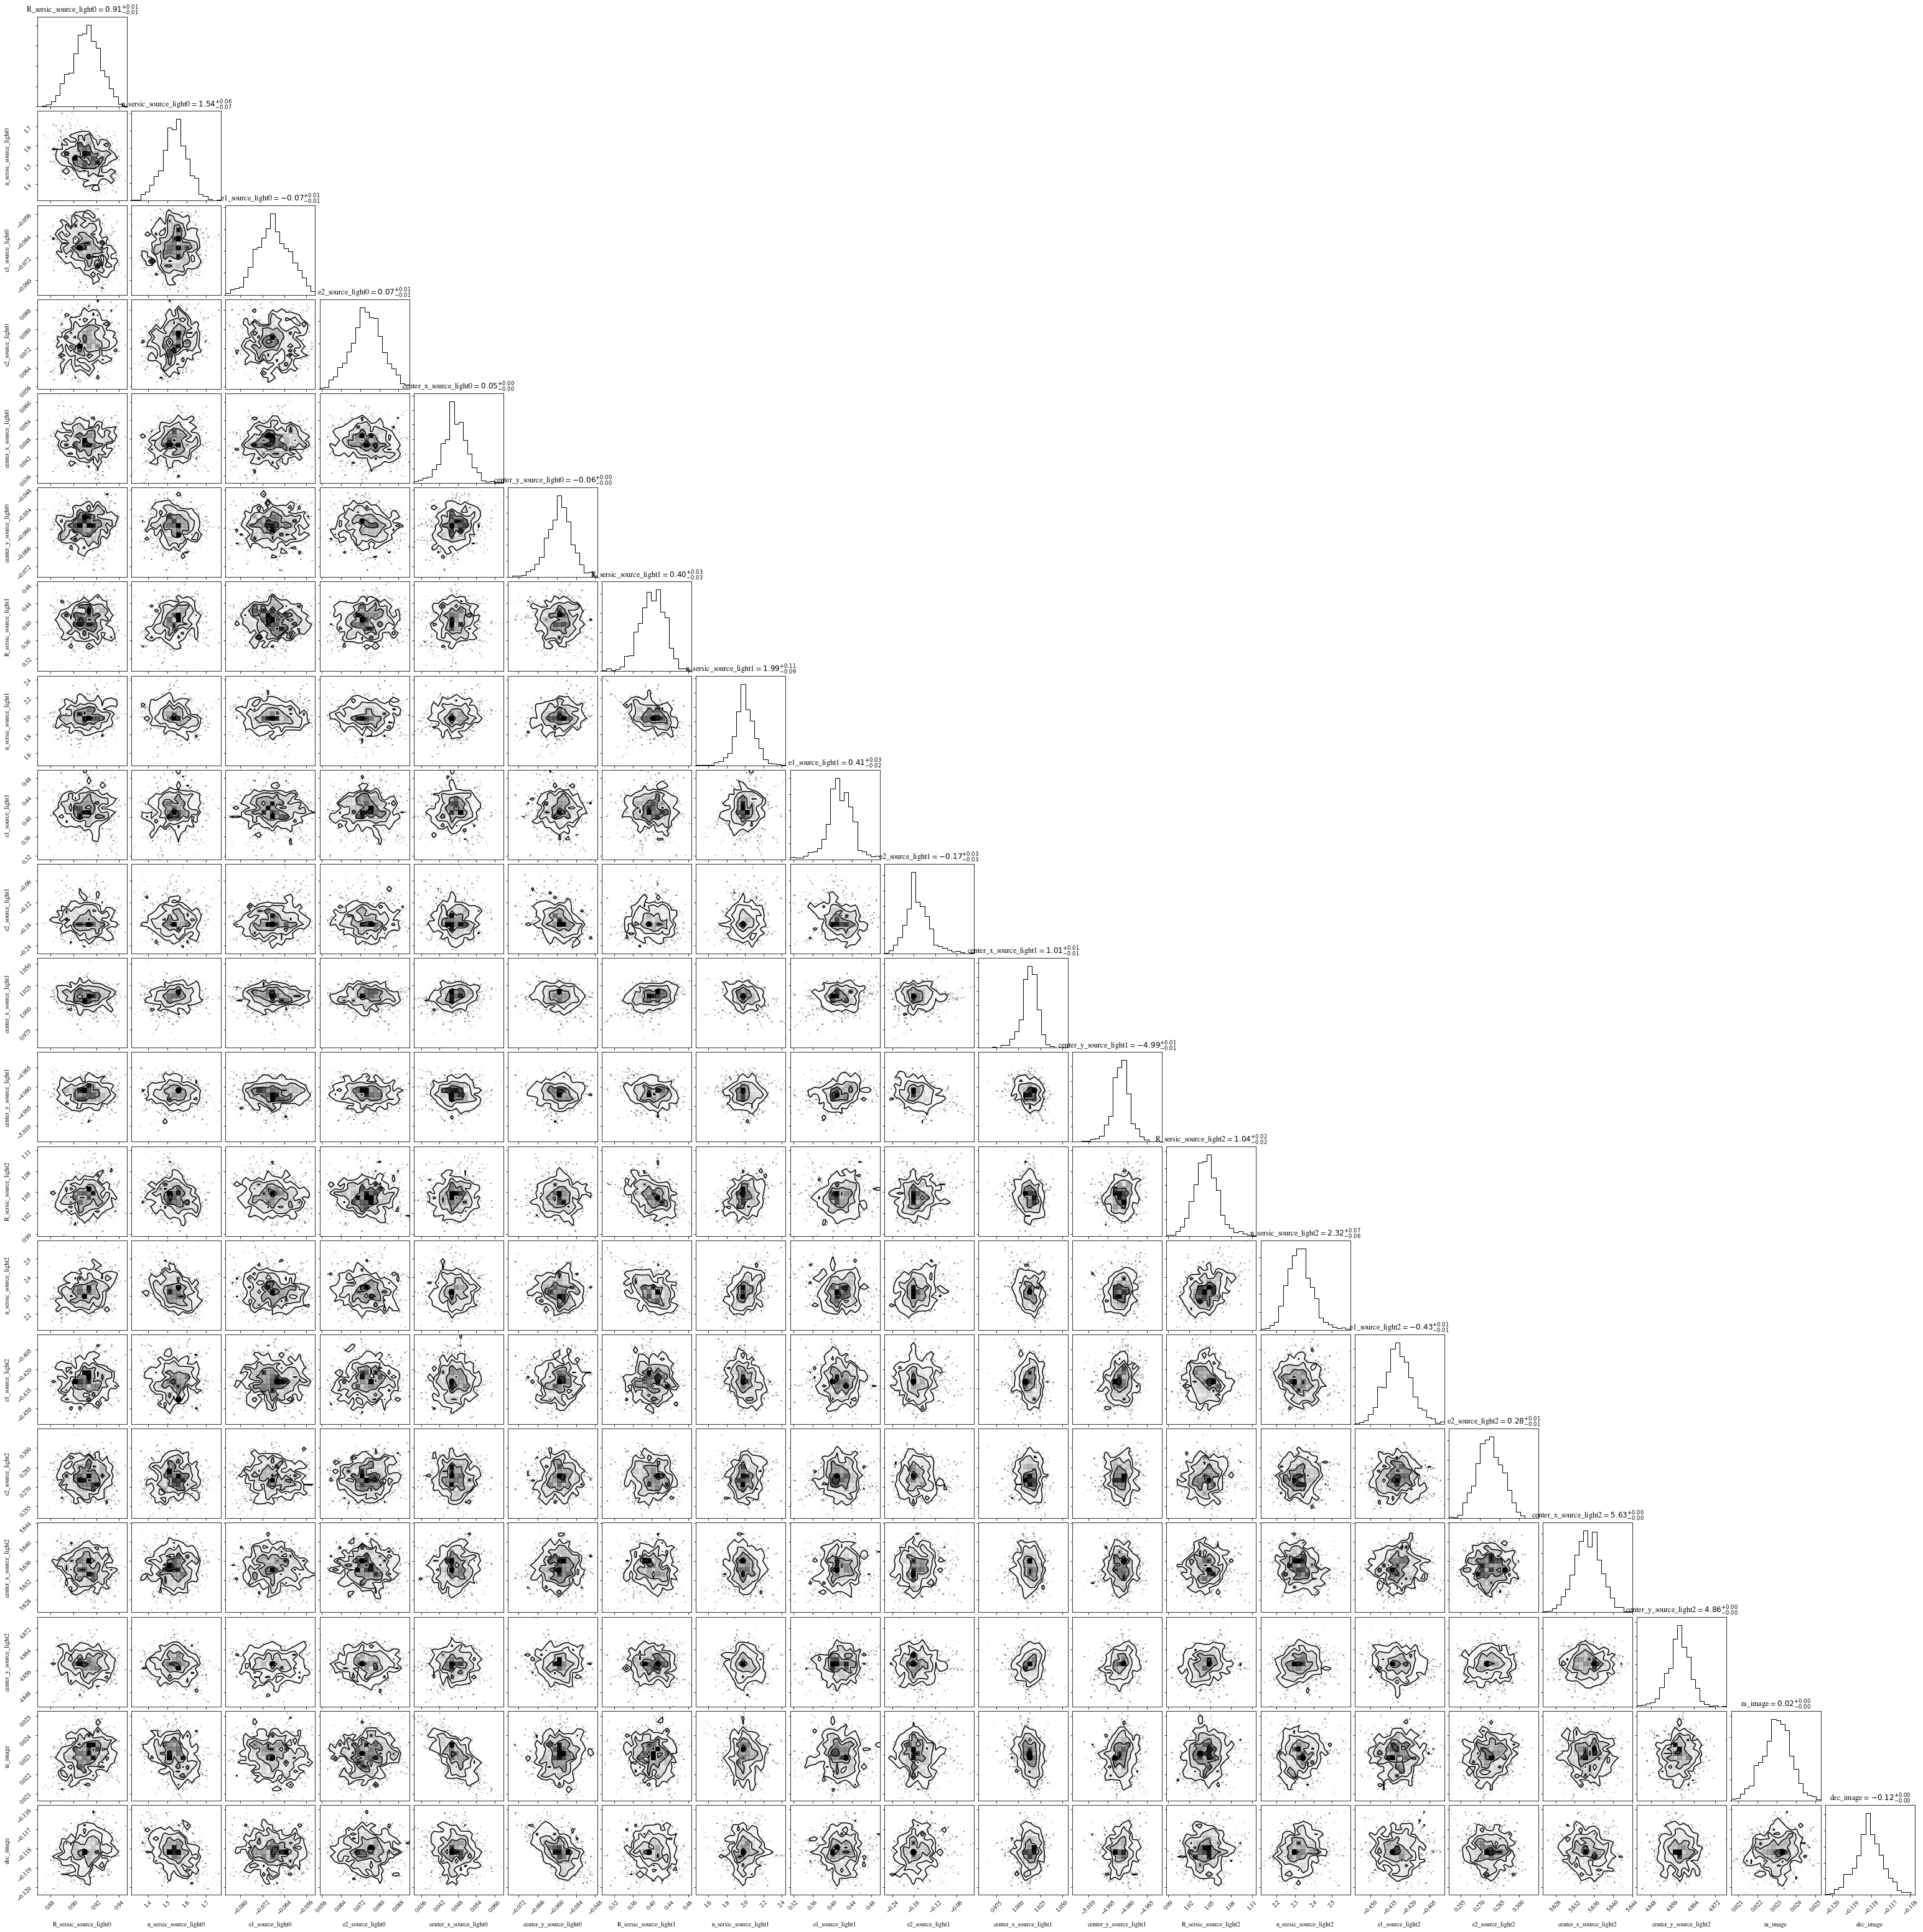

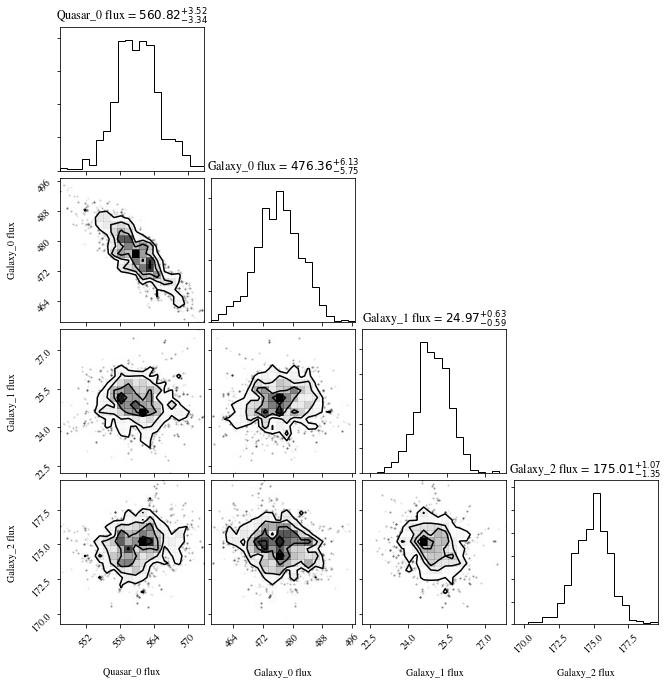

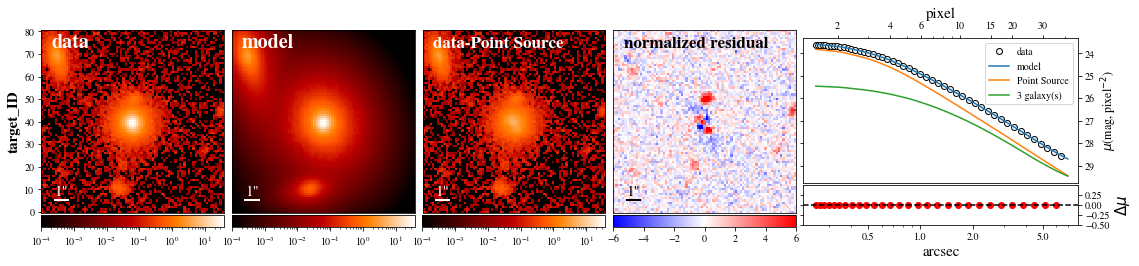

In [4]:
#Setting the fitting method and run.
from decomprofile.fitting_process import FittingProcess

#Pass fit_sepc to FittingProcess,
# savename: The name of the saved files.    
fit_run = FittingProcess(fit_sepc, savename = 'HSC_result')

#Setting the fitting approach and Run: 
#     algorithm_list: The fitting approaches that would be used: e.g. ['PSO', 'PSO', 'MCMC']
#     setting_list: The detailed setting for the fitting: e.g. [[0.8, 50, 50], [0.8, 50, 50], [50, 100, 10, 0.1]]
#     -for PSO:
#         [0.8, 50, 50] would input: {'sigma_scale': 0.8, 'n_particles': 50, 'n_iterations': 50}
#     -for MCMC:
#         [50, 100, 10, 0.1] would input: {'n_burn': 50, 'n_run': 100, 'walkerRatio': 10, 'sigma_scale': .1}
#     if setting_list = [None, None, None], default values would be given 
fit_run.run(algorithm_list = ['PSO', 'MCMC'], setting_list = [None, None])

# Plot all the fitting results, including:
#         run_diag() : The convergence of the chains.
#         model_plot(): The model plot (by lenstronomy)
#         plot_params_corner(): The mcmc corner for all the chains (MCMC should be peformed) 
#         plot_flux_corner(): The flux corner for all the component (MCMC should be peformed)
#         plot_final_qso_fit() or plot_final_galaxy_fit(): Plot the overall plot (data, model, data-ps, resudal, 1D profile)
fit_run.plot_all()

#Calculate the magnitude for each component, and translate e1, e1 to q, theta.
fit_run.translate_result()

#Save the fitting class as pickle format:
#     Note, if you use python3 (or 2), load with python3 (or 2)
fit_run.dump_result()

In [5]:
#Load the saved fitting class, the fitting_run_result would be the loaded as fit_run() in previous fittings.
import pickle
picklename = 'HSC_result.pkl'
fitting_run_result = pickle.load(open(picklename,'rb'))
#fitting_run_result.plot_final_qso_fit()
fitting_run_result.final_result_galaxy

[{'amp': 48.92137821079361,
  'R_sersic': 0.9116505437237824,
  'n_sersic': 1.470407685458267,
  'e1': -0.0721698100291541,
  'e2': 0.07034564099839903,
  'center_x': 0.044325166153364334,
  'center_y': -0.05741647683354435,
  'phi_G': 1.1844967947821294,
  'q': 0.8168903450664652,
  'flux_sersic_model': 470.60592429257633,
  'flux_within_frame': 470.43301154970584,
  'magnitude': 20.31875552562677},
 {'amp': 20.719822397182558,
  'R_sersic': 0.43056990674897844,
  'n_sersic': 1.982861001844914,
  'e1': 0.3834088319368969,
  'e2': -0.1369677010238043,
  'center_x': 1.0062218568663066,
  'center_y': -4.98176393348663,
  'phi_G': -0.17155357694110018,
  'q': 0.4213232982415867,
  'flux_sersic_model': 26.29426093639964,
  'flux_within_frame': 26.210833832957398,
  'magnitude': 23.45379790706768},
 {'amp': 31.856121806726385,
  'R_sersic': 1.0517560810884794,
  'n_sersic': 2.372513485468507,
  'e1': -0.43070864791173646,
  'e2': 0.27694651335622716,
  'center_x': 5.6367408917104775,
  'cen